![Egeria Logo](https://raw.githubusercontent.com/odpi/egeria/master/assets/img/ODPi_Egeria_Logo_color.png)

### Egeria Hands-On Lab
# Egeria Servers and Metadata for Rex Development

## Introduction

This notebook will use one OMAG Server Platform to start a pair of OMAG Servers, both with local Repositories. One server will be used as the public data catalog which will store the metadata describing the schema of an asset - in our example this is a relational database with tables and columns. This server will have a graph repository.
The other server will be used to store metadata generated by a discovery process and has an in-memory repository. 

It is useful to have different types of repository to allow testing of Rex with repositories with different levels of support for graph queries. The graph repository has full support, whereas the in-memory repository only supports getEntityNeighborhood.

The real-world flow that we are emulating is:
* an asset owner on-boards the asset in the public data catalog, specifying the asset and connection to it
* the discvovery service runs and generates a discovery analysis report, plus an RFA to the stewardship server
* the stewardship server examines the report and for each DataField it creates the corresponding schema object in the public data catalog - and ties it to the DataField in the discovery report.

Rather than using 3 servers, this notebook operates with 2 - 
* the asset and its schema are stored in the "Schema Server" 
* the discovery report artefacts are stored in the "Report Server" 

When a schema artefact is created in the Schema Server a relationship is created between the artefact and the corresponding DataField in the Report Server. Because the DataField is homed by the Report Server we need to enable enterprise services in the Schema Server so that it can locate the DataField entity.

TODO - include picture!!
![CTS-Cohort.png](../images/RexDevCohort.png)
> **Figure 1:** Cohort for Rex Development

## Starting up the Egeria platform

Start one OMAG Server Platform on which to run both the servers. The following is expecting port 8088 but change it as necessary.

We also need Apache Zookeeper and Apache Kafka.  


In [ ]:
%run ../common/globals.ipynb

import requests
import pprint
import json
import os
import time

platformURL = os.environ.get('platformURL','https://localhost:9443') 

def checkServerPlatform(testPlatformName, testPlatformURL):
    response = requests.get(testPlatformURL + "/open-metadata/platform-services/users/garygeeke/server-platform/origin/")
    if response.status_code == 200:
        print("   ...", testPlatformName, "at", testPlatformURL, "is active - ready to begin")
    else:
        print("   ...", testPlatformName, "at", testPlatformURL, "is down - start it before proceeding")

print ("\nChecking OMAG Server Platform availability...")
checkServerPlatform("OMAG Server Platform", platformURL)

print ("Done.")

## Create some general definitions

In [ ]:
success = True

Our servers will belong to the same cohort...

In [ ]:
devCohort        = "devCohort"

We'll need to pass a couple of JSON request bodies - so let's set up a reusable header:

In [ ]:
jsonContentHeader = {'content-type':'application/json'}

We'll need a JSON request body for configuration of the event bus.

In [ ]:
eventBusURLroot   = os.environ.get('eventBusURLroot', 'localhost:9092')

eventBusBody      = {
    "producer": {
        "bootstrap.servers": eventBusURLroot
    },
    "consumer":{
        "bootstrap.servers": eventBusURLroot
    }
}

We also need a userId for the configuration commands. You could change this to a name you choose.

In [ ]:
adminUserId      = "garygeeke"

We can perform configuration operations through the administrative interface provided by the platformURL.

The URLs for the configuration REST APIs have a common structure and begin with the following root:

In [ ]:
adminPlatformURL = platformURL

adminCommandURLRoot = adminPlatformURL + '/open-metadata/admin-services/users/' + adminUserId + '/servers/'

What follows are descriptions and coded requests to configure each server.  There are a lot of common steps 
involved in configuring a metadata server, so we first define some simple 
functions that can be re-used in later steps for configuring each server.

Each function returns True or False to indicate whether it was successful.

In [ ]:
def postAndPrintResult(url, json=None, headers=None):
    print("   ...... (POST", url, ")")
    response = requests.post(url, json=json, headers=headers)
    if response.status_code == 200:
        print("   ...... Success. Response: ", response.json())
        return True
    else:
        print("   ...... Failed. Response: ", response.json())
        return False
    
def postAndReturnResult(url, json=None, headers=None):
    #print("   ...... (POST", url, ")")
    response = requests.post(url, json=json, headers=headers)
    if response.status_code == 200:
        #print("   ...... Success. Response: ", response.json())
        return response.json()
    else:
        print("   ...... Failed. Response: ", response.json())
        return { "status" : "failed"}    
    
def getAndPrintResult(url, json=None, headers=None):
    print("   ...... (GET", url, ")")
    response = requests.get(url, json=json, headers=headers)
    if response.status_code == 200:
        print("   ...... Success. Response: ", response.json())
        return True
    else:
        print("   ...... Failed. Response: ", response.json())
        return False

def getResult(url, json=None, headers=None):
    print("\n   ...... (GET", url, ")")
    try:
        response = requests.get(url, json=json, headers=headers)
        if response.status_code == 200:
            if response.json()['relatedHTTPCode'] == 200:
                return response.json()
        return None
    except requests.exceptions.RequestException as e:
        print ("   ...... FAILED - http request threw an exception: ", e)
        return None    

def configurePlatformURL(serverName, serverPlatform):
    print("\n   ... Configuring the platform the server will run on...")
    url = adminCommandURLRoot + serverName + '/server-url-root?url=' + serverPlatform
    return postAndPrintResult(url)

def configureServerType(serverName, serverType):
    print ("\n   ... Configuring the server's type...")
    url = adminCommandURLRoot + serverName + '/server-type?typeName=' + serverType
    return postAndPrintResult(url)

def configureUserId(serverName, userId):
    print ("\n   ... Configuring the server's userId...")
    url = adminCommandURLRoot + serverName + '/server-user-id?id=' + userId
    return postAndPrintResult(url)

def configurePassword(serverName, password):
    print ("\n   ... Configuring the server's password (optional)...")
    url = adminCommandURLRoot + serverName + '/server-user-password?password=' + password
    return postAndPrintResult(url)

def configureMetadataRepository(serverName, repositoryType):
    print ("\n   ... Configuring the metadata repository...")
    url = adminCommandURLRoot + serverName + '/local-repository/mode/' + repositoryType
    return postAndPrintResult(url)

def configureDescriptiveName(serverName, collectionName):
    print ("\n   ... Configuring the short descriptive name of the metadata stored in this server...")
    url = adminCommandURLRoot + serverName + '/local-repository/metadata-collection-name/' + collectionName
    return postAndPrintResult(url)

def configureEventBus(serverName, busBody):
    print ("\n   ... Configuring the event bus for this server...")
    url = adminCommandURLRoot + serverName + '/event-bus'
    return postAndPrintResult(url, json=busBody, headers=jsonContentHeader)

def configureCohortMembership(serverName, cohortName):
    print ("\n   ... Configuring the membership of the cohort...")
    url = adminCommandURLRoot + serverName + '/cohorts/' + cohortName
    return postAndPrintResult(url)

def configureEnterpriseServices(serverName):
    print ("\n   ... Configuring enterprise access services...")
    url = adminCommandURLRoot + serverName + '/access-services'
    return postAndPrintResult(url)
    
def configureRepositoryWorkbench(serverName, workbenchBody):
    print ("\n   ... Configuring the repository workbench for this server...")
    url = adminCommandURLRoot + serverName + '/conformance-suite-workbenches/repository-workbench/repositories'
    return postAndPrintResult(url, json=workbenchBody, headers=jsonContentHeader)


 ## Configuring the Schema Server

We're going to the Schema Server. It hosts a local metadata repository so that we can perform Tex and Rex operations.
The server will default to using a local graph repository, which supports all the metadata collection interface graph methods.
The server does not need to run any Access Services.


In [ ]:
schemaServer       = "Schema_Server"
serverType                     = "Metadata Repository Server"
serverUserId                   = "npa"
serverPassword                 = "passw0rd"
metadataCollectionName         = "MDR"
metadataRepositoryTypeInMemory = "in-memory-repository"
metadataRepositoryTypeGraph    = "local-graph-repository"
serverPlatform                 = platformURL

print("Configuring " + schemaServer + "...")

if (success):
    success = configurePlatformURL(schemaServer, serverPlatform)
if (success):
    success = configureServerType(schemaServer, serverType)
if (success):
    success = configureUserId(schemaServer, serverUserId)
if (success):
    success = configurePassword(schemaServer, serverPassword)
if (success):
    success = configureMetadataRepository(schemaServer, metadataRepositoryTypeGraph)
if (success):
    success = configureDescriptiveName(schemaServer, metadataCollectionName)
if (success):
    success = configureEventBus(schemaServer, eventBusBody)
if (success):
    success = configureCohortMembership(schemaServer, devCohort)
if (success):
    success = configureEnterpriseServices(schemaServer)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")

The commands below deploy the server configuration documents to the server platforms where the
servers will run.

In [ ]:
def deployServerToPlatform(serverName, platformURL):
    print("   ... deploying", serverName, "to the", platformURL, "platform...")
    url = adminCommandURLRoot + serverName + '/configuration/deploy'
    platformTarget = {
        "class": "URLRequestBody",
        "urlRoot": platformURL
    }
    try:
        return postAndPrintResult(url, json=platformTarget, headers=jsonContentHeader)
    except requests.exceptions.RequestException as e:
        print ("   ...... FAILED - http request threw an exception: ", e)
        return False    




In [ ]:

print("\nDeploying server configuration document to platform...")
    

if (success):
    success = deployServerToPlatform(schemaServer, serverPlatform)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")

 ## Configuring the Report Server

We're going to configure the Report Server - this stores the metadata associated with a DiscoveryAnalysisReport.
It hosts a local metadata repository so that we can perform Tex and Rex operations.
The server will default to using a local in-memory repository, which does not support all the metadata collection interface graph methods.
The server does not need to run any Access Services.  !!!!!! TODO
Configure the Enterprise Services


In [ ]:
reportServer                   = "Report_Server"
serverType                     = "Metadata Repository Server"
serverUserId                   = "npa"
serverPassword                 = "passw0rd"
metadataCollectionName         = "MDR"
metadataRepositoryTypeInMemory = "in-memory-repository"
metadataRepositoryTypeGraph    = "local-graph-repository"
serverPlatform                 = platformURL

print("Configuring " + schemaServer + "...")

if (success):
    success = configurePlatformURL(reportServer, serverPlatform)
if (success):
    success = configureServerType(reportServer, serverType)
if (success):
    success = configureUserId(reportServer, serverUserId)
if (success):
    success = configurePassword(reportServer, serverPassword)
if (success):
    success = configureMetadataRepository(reportServer, metadataRepositoryTypeInMemory)
if (success):
    success = configureDescriptiveName(reportServer, metadataCollectionName)
if (success):
    success = configureEventBus(reportServer, eventBusBody)
if (success):
    success = configureCohortMembership(reportServer, devCohort)
if (success):
    success = configureEnterpriseServices(reportServer)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")

In [ ]:



print("\nDeploying server configuration document to platform...")
    

if (success):
    success = deployServerToPlatform(reportServer, serverPlatform)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")

## Starting the servers

We'll need to define the URL for the OMRS operational services API.

In [ ]:
operationalServicesURLcore = "/open-metadata/admin-services/users/" + adminUserId

### Start the Schema Server.


In [ ]:
def startServer(serverName, platformURL):
    print("   ... starting server", serverName, "...")
    url = platformURL + operationalServicesURLcore + '/servers/' + serverName + '/instance'
    return postAndPrintResult(url)

print ("\nStarting the Repository server ...")

if (success):
    success = startServer(schemaServer, platformURL)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")

### Start the Report Server.


In [ ]:
def startServer(serverName, platformURL):
    print("   ... starting server", serverName, "...")
    url = platformURL + operationalServicesURLcore + '/servers/' + serverName + '/instance'
    return postAndPrintResult(url)

print ("\nStarting the Repository server ...")

if (success):
    success = startServer(reportServer, platformURL)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")

## Get type information from the Schema Server

This is used for automatically converting typeName to typeGUID...

In [ ]:
import json

In [ ]:
def getCommand(serverName, commandURL, reqBody):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + commandURL
    return getResult(url, json=reqBody, headers=jsonContentHeader)

In [ ]:
commandURL = '/types/all'

typeDefGalleryResponse = getCommand(schemaServer, commandURL, None )

# Get the list of known types (as TypeDef)
#print("response:",typeDefGalleryResponse)
typeDefs = typeDefGalleryResponse["typeDefs"]
# Reorganise into a dict keyed by typeName...
typeDictionary = {}
for t in typeDefs:    
    typeName = t['name']
    typeDictionary[typeName] = t
#print("typeDictionary entry for AttachedComment",typeDictionary['AttachedComment'])

You can now look up a typeGUID just by supplying the typeName and looking up in the typeDictionary.

In [ ]:
def getTypeGUIDForTypeName(typeName):
    return typeDictionary[typeName]['guid']

print("typeGUID for AttachedComment is ", getTypeGUIDForTypeName('AttachedComment'))

## Reusable entity and relationship creation functions

In [ ]:
# The propertyType parameter should be "OM_PRIMITIVE_TYPE_STRING", "OM_PRIMITIVE_TYPE_INT", etc
def propertyValueTemplate(propertyType, propertyValue):
    return  { "class":"PrimitivePropertyValue",
       "instancePropertyCategory":"PRIMITIVE",
       "primitiveDefCategory":propertyType,
       "primitiveValue":propertyValue }

# Test
#propertyOneValue = propertyValueTemplate("OM_PRIMITIVE_TYPE_STRING","myValue")
#print("propertyValue :", propertyOneValue)

In [ ]:
def propertiesBuilder():
    return { "class":"InstanceProperties", "instanceProperties": {  }, "propertyNames":[],  "propertyCount":0 }

def addStringProperty(properties, propName, propValue):   
    newPropertyValue = propertyValueTemplate("OM_PRIMITIVE_TYPE_STRING", propValue)
    properties = addProperty(properties, propName, newPropertyValue)    
    return properties

def addIntegerProperty(properties, propName, propValue):   
    newPropertyValue = propertyValueTemplate("OM_PRIMITIVE_TYPE_INT", propValue)
    properties = addProperty(properties, propName, newPropertyValue)
    return properties

def addProperty(properties, propName, propertyValue):       
    properties['instanceProperties'][propName] = propertyValue
    properties['propertyNames'].append(propName)
    properties['propertyCount']=properties['propertyCount']+1
    return properties

# Test
#instanceProperties = propertiesBuilder()
#addStringProperty(instanceProperties,"aProperty","aValue")
#addIntegerProperty(instanceProperties,"bProperty","bValue")
#print("instanceProperties :", instanceProperties)

In [ ]:
def entityCreateRequestTemplate(typeName, properties):
    typeGUID = getTypeGUIDForTypeName(typeName)
    return { "class":"EntityCreateRequest", 
             "entityTypeGUID":typeGUID,
             "initialProperties": properties }


In [ ]:
def relationshipCreateRequestTemplate(typeName, entityOneGUID, entityTwoGUID, properties):
    typeGUID = getTypeGUIDForTypeName(typeName)
    return { "class":"RelationshipCreateRequest", 
             "relationshipTypeGUID":typeGUID,
             "entityOneGUID":entityOneGUID,
             "entityTwoGUID":entityTwoGUID,
             "initialProperties": properties }


In [ ]:
def instancePropertiesRequestTemplate(properties):    
    return { "class":"InstancePropertiesRequest",              
             "instanceProperties": properties }

In [ ]:
def createEntity(serverName, reqBody):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + '/instances/entity'
    return postAndReturnResult(url, json=reqBody, headers=jsonContentHeader)

In [ ]:
def createRelationship(serverName, reqBody):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + '/instances/relationship'
    return postAndReturnResult(url, json=reqBody, headers=jsonContentHeader)

In [ ]:
def createRelationshipEnterprise(serverName, reqBody):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + '/enterprise/instances/relationship'
    return postAndReturnResult(url, json=reqBody, headers=jsonContentHeader)

In [ ]:
def classifyEntity(serverName, entityGUID, classificationName, classificationProperties):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + '/instances/entity/' + entityGUID + '/classification/' + classificationName
    return postAndReturnResult(url, json=classificationProperties, headers=jsonContentHeader)

# Creation of schema metadata instances....

## Create a Process entity

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","process-qn001")
addStringProperty(instanceProperties,"displayName","onboarding-process")
addStringProperty(instanceProperties,"name","process-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Process",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
processGUID = entity["guid"]
print("\n processGUID",processGUID)

## Create a DataSet entity

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","dataset-qn001")
addStringProperty(instanceProperties,"name","dataset-1")
instanceCreateRequest = entityCreateRequestTemplate("DataSet",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
dataSetGUID = entity["guid"]
print("\n dataSetGUID",dataSetGUID)

## Relate Process and DataSet

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("DataContentForDataSet",processGUID,dataSetGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
dataContentForDataSetGUID = relationship["guid"]
print("\n dataContentForDataSetGUID",dataContentForDataSetGUID)

## Create a DataClass entity

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","dataclass-qn001")
addStringProperty(instanceProperties,"name","dataclass-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataClass",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
dataClassGUID = entity["guid"]
print("\n dataClassGUID",dataClassGUID)

## Relate Process and DataClass

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"steward","norma-liza")
#print("processProperties :", processProperties)
instanceCreateRequest = relationshipCreateRequestTemplate("DataClassAssignment",processGUID,dataClassGUID,instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
dataClassAssignmentGUID = relationship["guid"]
print("\n dataClassAssignmentGUID",dataClassAssignmentGUID)

## Create a Project entity

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","project-qn001")
addStringProperty(instanceProperties,"name","project-1")
addStringProperty(instanceProperties,"description","This is the description of project-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Project",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
projectGUID = entity["guid"]
print("\n projectGUID",projectGUID)

## Relate Project and DataSet

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("ProjectScope",projectGUID,dataSetGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
projectScopeGUID = relationship["guid"]
print("\n projectScopeGUID",projectScopeGUID)

## Create a ProjectCharter entity

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","projectcharter-qn001")
addStringProperty(instanceProperties,"mission","Mission for projectcharter-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("ProjectCharter",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
projectCharterGUID = entity["guid"]
print("\n projectCharterGUID",projectCharterGUID)

## Relate Project and ProjectCharter

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("ProjectCharterLink",projectGUID,projectCharterGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
projectCharterLinkGUID = relationship["guid"]
print("\n projectCharterLinkGUID",projectCharterLinkGUID)

## Create a DesignPattern entity

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","designpattern-qn001")
addStringProperty(instanceProperties,"context","Context for designpattern-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DesignPattern",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
designPatternGUID = entity["guid"]
print("\n designPatternGUID",designPatternGUID)

## Relate ProjectCharter and DesignPattern

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("MoreInformation",projectCharterGUID,designPatternGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
moreInformation1GUID = relationship["guid"]
print("\n moreInformation1GUID",moreInformation1GUID)

## Create a Community entity

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","community-qn001")
addStringProperty(instanceProperties,"name","community-1")
addStringProperty(instanceProperties,"mission","Mission for community-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Community",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
communityGUID = entity["guid"]
print("\n communityGUID",communityGUID)

## Relate ProjectCharter and Community

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("MoreInformation",projectCharterGUID,communityGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
moreInformation2GUID = relationship["guid"]
print("\n moreInformation2GUID",moreInformation2GUID)

## Instances from 'semantic-to-implementation' model

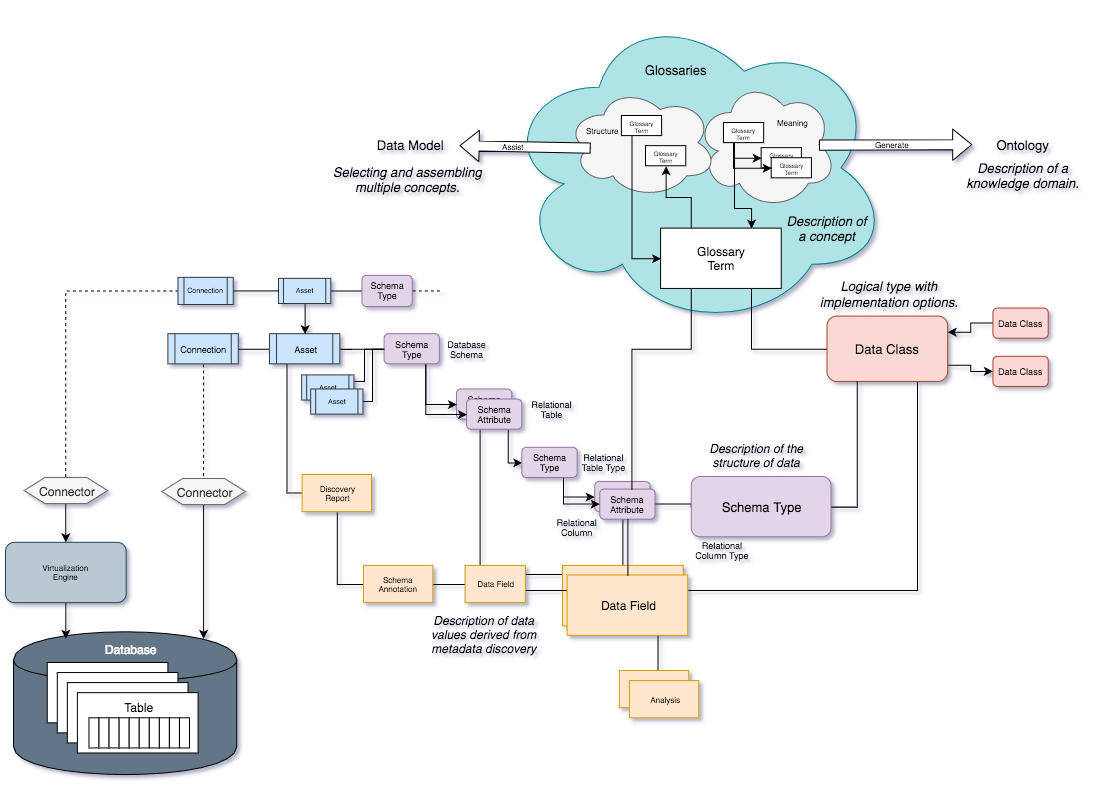

Thanks to Mandy for the above picture

The following cells create the larger (non-virtual) Asset and everything to the right and below it including the red DataClass instances. It does not create the GlossaryTerms (yet).

## Create Asset1, Asset2, Asset3

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","asset-qn001")
addStringProperty(instanceProperties,"name","asset-1")
addStringProperty(instanceProperties,"owner","owner-of-asset-1")
addStringProperty(instanceProperties,"description","Description of asset-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Asset",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
asset1_GUID = entity["guid"]
print("\n asset1_GUID",asset1_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","asset-qn002")
addStringProperty(instanceProperties,"name","asset-2")
addStringProperty(instanceProperties,"owner","owner-of-asset-2")
addStringProperty(instanceProperties,"description","Description of asset-2")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Asset",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
asset2_GUID = entity["guid"]
print("\n asset2_GUID",asset2_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","asset-qn003")
addStringProperty(instanceProperties,"name","asset-3")
addStringProperty(instanceProperties,"owner","owner-of-asset-3")
addStringProperty(instanceProperties,"description","Description of asset-3")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Asset",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
asset3_GUID = entity["guid"]
print("\n asset3_GUID",asset3_GUID)

## Create DatabaseSchema as a ComplexSchemaType

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","databaseschema-qn001")
addStringProperty(instanceProperties,"displayName","databaseschema-1")
addStringProperty(instanceProperties,"description","Database Schema 1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("ComplexSchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
databaseSchema_GUID = entity["guid"]
print("\n databaseSchema_GUID",databaseSchema_GUID)

## Relate DatabaseSchema with all three Assets (Asset1, Asset2, Asset3)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AssetSchemaType",asset1_GUID,databaseSchema_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
assetSchemaType1_GUID = relationship["guid"]
print("\n assetSchemaType1_GUID",assetSchemaType1_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AssetSchemaType",asset2_GUID,databaseSchema_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
assetSchemaType2_GUID = relationship["guid"]
print("\n assetSchemaType2_GUID",assetSchemaType2_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AssetSchemaType",asset3_GUID,databaseSchema_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
assetSchemaType3_GUID = relationship["guid"]
print("\n assetSchemaType3_GUID",assetSchemaType3_GUID)

## Create two RelationalTable SchemaAttributes

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationaltable-qn001")
addStringProperty(instanceProperties,"name","relationaltable-n1")
addStringProperty(instanceProperties,"displayName","relationaltable-1")
addStringProperty(instanceProperties,"description","Relational Table relationaltable-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalTable1_GUID = entity["guid"]
print("\n relationalTable1_GUID",relationalTable1_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationaltable-qn002")
addStringProperty(instanceProperties,"name","relationaltable-n2")
addStringProperty(instanceProperties,"displayName","relationaltable-2")
addStringProperty(instanceProperties,"description","Relational Table relationaltable-2")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalTable2_GUID = entity["guid"]
print("\n relationalTable2_GUID",relationalTable2_GUID)

## Relate the DatabaseSchema with RelationalTable1, RelationalTable2 

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",databaseSchema_GUID,relationalTable1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalTable1ForDatabaseSchema_GUID = relationship["guid"]
print("\n relationalTable1ForDatabaseSchema_GUID", relationalTable1ForDatabaseSchema_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",databaseSchema_GUID,relationalTable2_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalTable2ForDatabaseSchema_GUID = relationship["guid"]
print("\n relationalTable2ForDatabaseSchema_GUID",relationalTable2ForDatabaseSchema_GUID)

## Create RelationalTableTypes as ComplexSchemaTypes

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationaltabletype-qn001")
addStringProperty(instanceProperties,"displayName","relationaltabletype-1")
addStringProperty(instanceProperties,"description","Relational Table Type for RelationalTable1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("ComplexSchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalTableType1_GUID = entity["guid"]
print("\n relationalTableType1_GUID",relationalTableType1_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationaltabletype-qn002")
addStringProperty(instanceProperties,"displayName","relationaltabletype-2")
addStringProperty(instanceProperties,"description","Relational Table Type for RelationalTable2")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("ComplexSchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalTableType2_GUID = entity["guid"]
print("\n relationalTableType2_GUID",relationalTableType2_GUID)

## Relate RelationalTableType1 with RelationalTable1

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalTable1_GUID,relationalTableType1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalTableTypeForRelationalTable1_GUID = relationship["guid"]
print("\n relationalTableTypeForRelationalTable1_GUID",relationalTableTypeForRelationalTable1_GUID)

## Relate RelationalTableType2 with RelationalTable2

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalTable2_GUID,relationalTableType2_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalTableTypeForRelationalTable2_GUID = relationship["guid"]
print("\n relationalTableTypeForRelationalTable2_GUID",relationalTableTypeForRelationalTable2_GUID)

## For RelationalTableType1 create three Relational Columns (11, 12 and 13)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn11-qname")
addStringProperty(instanceProperties,"name","relationalColumn11-name")
addStringProperty(instanceProperties,"displayName","relationalColumn11-displayName")
addStringProperty(instanceProperties,"description","Relational Column 11")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn11_GUID = entity["guid"]
print("\n relationalColumn11_GUID",relationalColumn11_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn12-qname")
addStringProperty(instanceProperties,"name","relationalColumn12-name")
addStringProperty(instanceProperties,"displayName","relationalColumn12-displayName")
addStringProperty(instanceProperties,"description","Relational Column 12")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn12_GUID = entity["guid"]
print("\n relationalColumn12_GUID",relationalColumn12_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn13-qname")
addStringProperty(instanceProperties,"name","relationalColumn13-name")
addStringProperty(instanceProperties,"displayName","relationalColumn13-displayName")
addStringProperty(instanceProperties,"description","Relational Column 13")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn13_GUID = entity["guid"]
print("\n relationalColumn13_GUID",relationalColumn13_GUID)

## Classify the Relational Columns

Relational Column 11 will have Retention classification (only).

Relational Column 12 will have Retention and Confidentiality classifications.

Relational Column 13 will have no classifications.

### Add a Confidentiality classification to Relational Column (12)

In [ ]:
classificationProperties = propertiesBuilder()
# Proper line - addIntegerProperty(classificationProperties,"level",2)
# Test line below - 
addStringProperty(classificationProperties,"level","2")
addStringProperty(classificationProperties,"source","CorporateDirective-CD112")
addStringProperty(classificationProperties,"steward","data-sec-12345")
print("classificationProperties :", classificationProperties)

instancePropertiesRequest = instancePropertiesRequestTemplate(classificationProperties)

#classificationCreateRequest = classificationCreateRequestTemplate("Confidentiality",classificationProperties)
#print("classificationCreateRequest:",classificationCreateRequest)

classifyEntityResponse = classifyEntity(schemaServer, relationalColumn12_GUID, "Confidentiality", instancePropertiesRequest)
print("classifyEntityResponse:",classifyEntityResponse)

#classification = classifyEntityResponse["classification"]
#relationalColumn11_GUID = entity["guid"]
#print("\n relationalColumn11_GUID",relationalColumn11_GUID)
#print("\n classification is ... ",classification)

### Add a Retention classification to Relational Columns (11 and 12)

In [ ]:
classificationProperties = propertiesBuilder()
addStringProperty(classificationProperties,"notes","Data to be retained for 24 months")
addStringProperty(classificationProperties,"source","CorporateDirective-CD109")
addStringProperty(classificationProperties,"steward","data-records-007")
print("classificationProperties :", classificationProperties)

instancePropertiesRequest = instancePropertiesRequestTemplate(classificationProperties)

classifyEntityResponse = classifyEntity(schemaServer, relationalColumn11_GUID, "Retention", instancePropertiesRequest)
#print("\n classifyEntityResponse:",classifyEntityResponse)

classifyEntityResponse = classifyEntity(schemaServer, relationalColumn12_GUID, "Retention", instancePropertiesRequest)
#print("\n classifyEntityResponse:",classifyEntityResponse)

## Relate RelationalColumns 11, 12 and 13 to RelationalTableType1


In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType1_GUID,relationalColumn11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn11ForRelationalTableType1_GUID = relationship["guid"]
print("\n relationalColumn11ForRelationalTableType1_GUID",relationalColumn11ForRelationalTableType1_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType1_GUID,relationalColumn12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn12ForRelationalTableType1_GUID = relationship["guid"]
print("\n relationalColumn12ForRelationalTableType1_GUID",relationalColumn12ForRelationalTableType1_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType1_GUID,relationalColumn13_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn13ForRelationalTableType1_GUID = relationship["guid"]
print("\n relationalColumn13ForRelationalTableType1_GUID",relationalColumn13ForRelationalTableType1_GUID)

## For RelationalTableType2 create two Relational Columns (21 and 22)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn21-qname")
addStringProperty(instanceProperties,"name","relationalColumn21-name")
addStringProperty(instanceProperties,"displayName","relationalColumn21-displayName")
addStringProperty(instanceProperties,"description","Relational Column 21")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn21_GUID = entity["guid"]
print("\n relationalColumn21_GUID",relationalColumn21_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn22-qname")
addStringProperty(instanceProperties,"name","relationalColumn22-name")
addStringProperty(instanceProperties,"displayName","relationalColumn22-displayName")
addStringProperty(instanceProperties,"description","Relational Column 22")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn22_GUID = entity["guid"]
print("\n relationalColumn22_GUID",relationalColumn22_GUID)

## Relate RelationalColumn21, RelationalColumn22 with RelationalTableType2


In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType2_GUID,relationalColumn21_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn21ForRelationalTableType2_GUID = relationship["guid"]
print("\n relationalColumn21ForRelationalTableType2_GUID",relationalColumn21ForRelationalTableType2_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType2_GUID,relationalColumn22_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn22ForRelationalTableType2_GUID = relationship["guid"]
print("\n relationalColumn22ForRelationalTableType2_GUID",relationalColumn22ForRelationalTableType2_GUID)

## For RelationalColumn11 create a RelationalColumnType

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumnType11-qname")
addStringProperty(instanceProperties,"displayName","relationalColumnType11-displayName")
addStringProperty(instanceProperties,"description","Relational Column Type for RelationalColumn11")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalColumnType11_GUID = entity["guid"]
print("\n relationalColumnType11_GUID",relationalColumnType11_GUID)

## Relate RelationalColumn11 and RelationalColumnType11

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalColumn11_GUID,relationalColumnType11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumnType11ForRelationalColumn11_GUID = relationship["guid"]
print("\n relationalColumnType11ForRelationalColumn11_GUID",relationalColumnType11ForRelationalColumn11_GUID)

## For RelationalColumn12 create a RelationalColumnType

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumnType12-qname")
addStringProperty(instanceProperties,"displayName","relationalColumnType12-displayName")
addStringProperty(instanceProperties,"description","Relational Column Type for RelationalColumn12")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalColumnType12_GUID = entity["guid"]
print("\n relationalColumnType12_GUID",relationalColumnType12_GUID)

## Relate RelationalColumn12 and RelationalColumnType12

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalColumn12_GUID,relationalColumnType12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumnType12ForRelationalColumn12_GUID = relationship["guid"]
print("\n relationalColumnType12ForRelationalColumn12_GUID",relationalColumnType12ForRelationalColumn12_GUID)

## For RelationalColumn21 create a RelationalColumnType

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumnType21-qname")
addStringProperty(instanceProperties,"displayName","relationalColumnType21-displayName")
addStringProperty(instanceProperties,"description","Relational Column Type for RelationalColumn21")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalColumnType21_GUID = entity["guid"]
print("\n relationalColumnType21_GUID",relationalColumnType21_GUID)

## Relate RelationalColumn21 and RelationalColumnType21

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalColumn21_GUID,relationalColumnType21_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumnType21ForRelationalColumn21_GUID = relationship["guid"]
print("\n relationalColumnType21ForRelationalColumn21_GUID",relationalColumnType21ForRelationalColumn21_GUID)

## For RelationalColumn22 create a RelationalColumnType

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumnType22-qname")
addStringProperty(instanceProperties,"displayName","relationalColumnType22-displayName")
addStringProperty(instanceProperties,"description","Relational Column Type for RelationalColumn22")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalColumnType22_GUID = entity["guid"]
print("\n relationalColumnType22_GUID",relationalColumnType22_GUID)

## Relate RelationalColumn22 and RelationalColumnType22

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalColumn22_GUID,relationalColumnType22_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumnType22ForRelationalColumn22_GUID = relationship["guid"]
print("\n relationalColumnType22ForRelationalColumn22_GUID",relationalColumnType22ForRelationalColumn22_GUID)

# Add the Discovery Report and Annotations...

### Add a DiscoveryReport to Asset1

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","discoveryReport1-qname")
addStringProperty(instanceProperties,"displayName","discoveryReport1-displayName")
addStringProperty(instanceProperties,"description","Discovery Analysis Report for Asset1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("OpenDiscoveryAnalysisReport",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
discoveryReport1_GUID = entity["guid"]
print("\n discoveryReport1_GUID",discoveryReport1_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("AssetDiscoveryReport",asset1_GUID,discoveryReport1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveryReportForAsset1_GUID = relationship["guid"]
print("\n discoveryReportForAsset1_GUID",discoveryReportForAsset1_GUID)

### Add a SchemaAnnotation to the DiscoveryReport

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"explanation","schemaAnalysisAnnotation1-explanation")
addStringProperty(instanceProperties,"schemaName","schemaName-databaseSchema")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAnalysisAnnotation",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
schemaAnalysisAnnotation1_GUID = entity["guid"]
print("\n schemaAnalysisAnnotation1_GUID",schemaAnalysisAnnotation1_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("DiscoveredAnnotation",schemaAnalysisAnnotation1_GUID,discoveryReport1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveredAnnotation1ForDiscoveryReport_GUID = relationship["guid"]
print("\n discoveredAnnotation1ForDiscoveryReport_GUID",discoveredAnnotation1ForDiscoveryReport_GUID)

### Add a DataField that will relate to the RelationalTable

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"dataFieldName","dataFieldForRelationalTable1-name")
addStringProperty(instanceProperties,"dataFieldDescription","dataFieldForRelationalTable1-description")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataField",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldForRelationalTable1_GUID = entity["guid"]
print("\n dataFieldForRelationalTable1_GUID",dataFieldForRelationalTable1_GUID)

Associate the DataField with the SchemaAnalysisAnnotation

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("DiscoveredDataField",schemaAnalysisAnnotation1_GUID,dataFieldForRelationalTable1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveredDataFieldForRelationalTable1_GUID = relationship["guid"]
print("\n discoveredDataFieldForRelationalTable1_GUID", discoveredDataFieldForRelationalTable1_GUID)

Associate the DataField with the RelationalTable

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeDefinition",dataFieldForRelationalTable1_GUID,relationalTable1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
schemaAttributeDefinitionForRelationalTable1_GUID = relationship["guid"]
print("\n schemaAttributeDefinitionForRelationalTable1_GUID", schemaAttributeDefinitionForRelationalTable1_GUID)

### Add a DataField for each RelationalColumn in RelationalTable1

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"dataFieldName","dataFieldForRelationalColumn11-name")
addStringProperty(instanceProperties,"dataFieldDescription","dataFieldForRelationalColumn11-description")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataField",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldForRelationalColumn11_GUID = entity["guid"]
print("\n dataFieldForRelationalColumn11_GUID",dataFieldForRelationalColumn11_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("DiscoveredNestedDataField",dataFieldForRelationalTable1_GUID,dataFieldForRelationalColumn11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveredNestedDataFieldForRelationalColumn11_GUID = relationship["guid"]
print("\n discoveredNestedDataFieldForRelationalColumn11_GUID", discoveredNestedDataFieldForRelationalColumn11_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeDefinition",dataFieldForRelationalColumn11_GUID,relationalColumn11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
schemaAttributeDefinitionForRelationalColumn11_GUID = relationship["guid"]
print("\n schemaAttributeDefinitionForRelationalColumn11_GUID", schemaAttributeDefinitionForRelationalColumn11_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"dataFieldName","dataFieldForRelationalColumn12-name")
addStringProperty(instanceProperties,"dataFieldDescription","dataFieldForRelationalColumn12-description")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataField",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldForRelationalColumn12_GUID = entity["guid"]
print("\n dataFieldForRelationalColumn12_GUID",dataFieldForRelationalColumn12_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("DiscoveredNestedDataField",dataFieldForRelationalTable1_GUID,dataFieldForRelationalColumn12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveredNestedDataFieldForRelationalColumn12_GUID = relationship["guid"]
print("\n discoveredNestedDataFieldForRelationalColumn12_GUID", discoveredNestedDataFieldForRelationalColumn12_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeDefinition",dataFieldForRelationalColumn12_GUID,relationalColumn12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
schemaAttributeDefinitionForRelationalColumn12_GUID = relationship["guid"]
print("\n schemaAttributeDefinitionForRelationalColumn12_GUID", schemaAttributeDefinitionForRelationalColumn12_GUID)

### Add an Annotation for each DataField for each RelationalColumn in RelationalTable1

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"expression","dataFieldAnnotationForRelationalColumn11-expression")
addStringProperty(instanceProperties,"explanation","dataFieldAnnotationForRelationalColumn11-explanation")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataFieldAnnotation",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldAnnotationForRelationalColumn11_GUID = entity["guid"]
print("\n dataFieldAnnotationForRelationalColumn11_GUID", dataFieldAnnotationForRelationalColumn11_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("DataFieldAnalysis",dataFieldAnnotationForRelationalColumn11_GUID,dataFieldForRelationalColumn11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
dataFieldAnalysisForAnnotationForRelationalColumn11_GUID = relationship["guid"]
print("\n dataFieldAnalysisForAnnotationForRelationalColumn11_GUID", dataFieldAnalysisForAnnotationForRelationalColumn11_GUID)

In [ ]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"expression","dataFieldAnnotationForRelationalColumn12-expression")
addStringProperty(instanceProperties,"explanation","dataFieldAnnotationForRelationalColumn12-explanation")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataFieldAnnotation",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldAnnotationForRelationalColumn12_GUID = entity["guid"]
print("\n dataFieldAnnotationForRelationalColumn12_GUID", dataFieldAnnotationForRelationalColumn12_GUID)

In [ ]:
instanceCreateRequest = relationshipCreateRequestTemplate("DataFieldAnalysis",dataFieldAnnotationForRelationalColumn12_GUID,dataFieldForRelationalColumn12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
dataFieldAnalysisForAnnotationForRelationalColumn12_GUID = relationship["guid"]
print("\n dataFieldAnalysisForAnnotationForRelationalColumn12_GUID", dataFieldAnalysisForAnnotationForRelationalColumn12_GUID)